In [2]:
from euler_gpu.grid_search import grid_search
from euler_gpu.preprocess import initialize, max_intensity_projection_and_downsample
from euler_gpu.transform import transform_image_3d, translate_along_z
from preprocess import filter_and_crop, crop
from tqdm import tqdm
from util import DATASETS_SPLIT_DICT, get_image_T, get_cropped_image, get_image_CM, locate_directory, calculate_gncc
import glob
import h5py
import json
import numpy as np
import os
import torch

#### examine registered image at each intermediate stage of grid search

In [3]:
resolution_factor = 1
x_translation_range = np.linspace(-1, 1, int(100/resolution_factor),
        dtype=np.float32)
y_translation_range = np.linspace(-1, 1, int(100/resolution_factor),
        dtype=np.float32)
theta_rotation_range = np.linspace(0, 360, int(360/resolution_factor),
        dtype=np.float32)
z_translation_range = range(-50, 50)
batch_size = 208
device_name = torch.device("cuda:3")
downsample_factor = 1

x_dim = 208
y_dim = 96
z_dim = 56

memory_dict_xy = initialize(
            np.zeros((x_dim, y_dim)).astype(np.float32),
            np.zeros((x_dim, y_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            batch_size,
            device_name
)
_memory_dict_xy = initialize(
            np.zeros((x_dim, y_dim)).astype(np.float32),
            np.zeros((x_dim, y_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            z_dim,
            device_name
)

memory_dict_xz = initialize(
            np.zeros((x_dim, z_dim)).astype(np.float32),
            np.zeros((x_dim, z_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            batch_size,
            device_name
)
_memory_dict_xz = initialize(
            np.zeros((x_dim, z_dim)).astype(np.float32),
            np.zeros((x_dim, z_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            y_dim,
            device_name
)
memory_dict_yz = initialize(
            np.zeros((y_dim, z_dim)).astype(np.float32),
            np.zeros((y_dim, z_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            batch_size,
            device_name
)
_memory_dict_yz = initialize(
            np.zeros((y_dim, z_dim)).astype(np.float32),
            np.zeros((y_dim, z_dim)).astype(np.float32),
            x_translation_range,
            y_translation_range,
            theta_rotation_range,
            x_dim,
            device_name
)

outcomes = dict()
dataset_type_n_name = 'train/2022-01-09-01'
problems = ['122to641']

dataset_type, dataset_name = dataset_type_n_name.split('/')
dataset_path = locate_directory(dataset_name)


for problem in tqdm(problems):

    outcomes[f"{dataset_name}/{problem}"] = dict()

    t_moving, t_fixed = problem.split('to')
    t_moving_4 = t_moving.zfill(4)
    t_fixed_4 = t_fixed.zfill(4)
    fixed_image_path = glob.glob(
            f'{dataset_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
    )[0]
    moving_image_path = glob.glob(
            f'{dataset_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
    )[0]

    fixed_image_T = get_image_T(fixed_image_path)
    fixed_image_median = np.median(fixed_image_T)
    moving_image_T = get_image_T(moving_image_path)
    moving_image_median = np.median(moving_image_T)

    resized_fixed_image_xyz = filter_and_crop(fixed_image_T,
                fixed_image_median)
    
    # prepare reshaped fixed images for later use
    resized_fixed_image_xzy = np.transpose(resized_fixed_image_xyz, (0, 2, 1))
    resized_fixed_image_yzx = np.transpose(resized_fixed_image_xyz, (1, 2, 0))
    
    resized_moving_image_xyz = filter_and_crop(moving_image_T,
                moving_image_median)
    
    #########################################
    #########################################
    #########################################
    
    # project onto the x-y plane along the maximum z
    
    downsampled_resized_fixed_image_xy = \
            max_intensity_projection_and_downsample(
                    resized_fixed_image_xyz,
                    downsample_factor,
                    projection_axis=2).astype(np.float32)
    downsampled_resized_moving_image_xy = \
            max_intensity_projection_and_downsample(
                    resized_moving_image_xyz,
                    downsample_factor,
                    projection_axis=2).astype(np.float32)

    # update the memory dictionary for grid search on x-y image
    
    memory_dict_xy["fixed_images_repeated"][:] = torch.tensor(
                downsampled_resized_fixed_image_xy,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)
    memory_dict_xy["moving_images_repeated"][:] = torch.tensor(
                downsampled_resized_moving_image_xy,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    # search optimal parameters with projected image on the x-y plane
    
    best_score_xy, best_transformation_xy = grid_search(memory_dict_xy)
    outcomes[f"{dataset_name}/{problem}"]["registered_image_xyz_gncc_xy"] = best_score_xy.item()

    print(f"x-y score (best): {best_score_xy}")
    print(f"best_transformation_xy: {best_transformation_xy}")

    # transform the 3d image with the searched parameters
    
    transformed_moving_image_xyz = transform_image_3d(
                resized_moving_image_xyz,
                _memory_dict_xy,
                best_transformation_xy,
                device_name
    )
    
    registered_image_xyz_gncc_yz = calculate_gncc(
            resized_fixed_image_xyz.max(0),
            transformed_moving_image_xyz.max(0)
    )
    
    print(f"y-z score: {registered_image_xyz_gncc_yz}")
    outcomes[f"{dataset_name}/{problem}"]["registered_image_xyz_gncc_yz"] = registered_image_xyz_gncc_yz.item()
    

    registered_image_xyz_gncc_xz = calculate_gncc(
            resized_fixed_image_xyz.max(1),
            transformed_moving_image_xyz.max(1)
    )
    print(f"x-z score: {registered_image_xyz_gncc_xz}")
    outcomes[f"{dataset_name}/{problem}"]["registered_image_xyz_gncc_xz"] = registered_image_xyz_gncc_xz.item()
    

    registered_image_xyz_gncc_xyz = calculate_gncc(
            resized_fixed_image_xyz,
            transformed_moving_image_xyz
    )
    print(f"full image score: {registered_image_xyz_gncc_xyz}")
    outcomes[f"{dataset_name}/{problem}"]["registered_image_xyz_gncc_xyz"] = registered_image_xyz_gncc_xyz.item()
    
    #########################################
    #########################################
    #########################################
    
    # project onto the x-z plane along the maximum y
    
    downsampled_resized_fixed_image_xz = \
                max_intensity_projection_and_downsample(
                        resized_fixed_image_xyz,
                        downsample_factor,
                        projection_axis=1).astype(np.float32)

    downsampled_resized_moving_image_xz = \
                max_intensity_projection_and_downsample(
                        transformed_moving_image_xyz,
                        downsample_factor,
                        projection_axis=1).astype(np.float32)

    # update the memory dictionary for grid search on x-z image
    
    memory_dict_xz["fixed_images_repeated"][:] = torch.tensor(
                downsampled_resized_fixed_image_xz,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    memory_dict_xz["moving_images_repeated"][:] = torch.tensor(
                downsampled_resized_moving_image_xz,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    memory_dict_xz['output_tensor'][:] = torch.zeros_like(
                memory_dict_xz["moving_images_repeated"][:],
                device=device_name,
                dtype=torch.float32)

    # search optimal parameters with projected image on the x-y plane
    
    best_score_xz, best_transformation_xz = grid_search(memory_dict_xz)
    
    print(f"x-z score (best): {best_score_xz}")
    print(f"best_transformation_xz: {best_transformation_xz}")
    
    outcomes[f"{dataset_name}/{problem}"]["x-z_score_best"] = best_score_xz.item()


    # transform the 3d image with the searched parameters

    transformed_moving_image_xzy = transform_image_3d(
                # need to transpose the input moving image to the target shape
                np.transpose(transformed_moving_image_xyz, (0, 2, 1)),
                _memory_dict_xz,
                best_transformation_xz,
                device_name
    )

    transformed_moving_image_xzy_gncc_yz = calculate_gncc(
                # reshape resized_fixed_image_xyz to xzy - then project to y-z plane
                resized_fixed_image_xzy.max(0),
                transformed_moving_image_xzy.max(0)
    )
    print(f"y-z score: {transformed_moving_image_xzy_gncc_yz}")
    outcomes[f"{dataset_name}/{problem}"]["transformed_moving_image_xzy_gncc_yz"] = transformed_moving_image_xzy_gncc_yz.item()
    
    transformed_moving_image_xzy_gncc_xy = calculate_gncc(
            resized_fixed_image_xzy.max(1),
            transformed_moving_image_xzy.max(1)
    )
    print(f"x-y score: {transformed_moving_image_xzy_gncc_xy}")
    outcomes[f"{dataset_name}/{problem}"]["transformed_moving_image_xzy_gncc_xy"] = transformed_moving_image_xzy_gncc_xy.item()

    registered_image_xzy_gncc_xzy = calculate_gncc(
            resized_fixed_image_xzy,
            transformed_moving_image_xzy)
    print(f"full image score: {registered_image_xzy_gncc_xzy}")
    outcomes[f"{dataset_name}/{problem}"]["registered_image_xzy_gncc_xzy"] = registered_image_xzy_gncc_xzy.item()

    #########################################
    #########################################
    #########################################
    
    # project onto the y-z plane along the maximum x
    
    downsampled_resized_fixed_image_yz = \
                max_intensity_projection_and_downsample(
                        resized_fixed_image_xyz,
                        downsample_factor,
                        projection_axis=0).astype(np.float32)
    downsampled_resized_moving_image_yz = \
                max_intensity_projection_and_downsample(
                        np.transpose(transformed_moving_image_xzy, (0, 2, 1)),
                        downsample_factor,
                        projection_axis=0).astype(np.float32)

    memory_dict_yz["fixed_images_repeated"][:] = torch.tensor(
                downsampled_resized_fixed_image_yz,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    memory_dict_yz["moving_images_repeated"][:] = torch.tensor(
                downsampled_resized_moving_image_yz,
                device=device_name,
                dtype=torch.float32).unsqueeze(0).repeat(batch_size, 1, 1, 1)

    memory_dict_yz['output_tensor'][:] = torch.zeros_like(
                memory_dict_yz["moving_images_repeated"][:],
                device=device_name,
                dtype=torch.float32)

    # search optimal parameters with projected image on the y-z plane
    
    best_score_yz, best_transformation_yz = grid_search(memory_dict_yz)
    outcomes[f"{dataset_name}/{problem}"]["y-z_score_best"] = best_score_yz.item()
    print(f"y-z score (best): {best_score_yz}")
    print(f"best_transformation_yz: {best_transformation_yz}")

    # transform the 3d image with the searched parameters
    
    transformed_moving_image_yzx = transform_image_3d(
                np.transpose(transformed_moving_image_xzy, (2, 1, 0)),
                _memory_dict_yz,
                best_transformation_yz,
                device_name
    )

    transformed_moving_image_yzx_gncc_xz = calculate_gncc(
            resized_fixed_image_yzx.max(0),
            transformed_moving_image_yzx.max(0)
    )
    print(f"x-z score: {transformed_moving_image_yzx_gncc_xz}")
    outcomes[f"{dataset_name}/{problem}"]["transformed_moving_image_yzx_gncc_xz"] = transformed_moving_image_yzx_gncc_xz.item()
    
    transformed_moving_image_yzx_gncc_xy = calculate_gncc(
            resized_fixed_image_yzx.max(1),
            transformed_moving_image_yzx.max(1)
    )
    outcomes[f"{dataset_name}/{problem}"]["transformed_moving_image_yzx_gncc_xy"] = transformed_moving_image_yzx_gncc_xy.item()
    print(f"x-y score: {transformed_moving_image_yzx_gncc_xy}")

    registered_image_yzx_gncc_yzx = calculate_gncc(
            resized_fixed_image_yzx,
            transformed_moving_image_yzx
    )
    print(f"full image score: {registered_image_yzx_gncc_yzx}")
    outcomes[f"{dataset_name}/{problem}"]["registered_image_yzx_gncc_yzx"] = registered_image_yzx_gncc_yzx.item()
    

    # search for the optimal dz translation
    dz, gncc, final_moving_image_xyz = translate_along_z(
                z_translation_range,
                resized_fixed_image_xyz,
                np.transpose(transformed_moving_image_yzx, (2, 0, 1)),
                moving_image_median
    )
    
    final_score = calculate_gncc(
                resized_fixed_image_xyz,
                final_moving_image_xyz)
    outcomes[f"{dataset_name}/{problem}"]["final_full_image_score"] = final_score.item()
    print(f"final_score: {final_score}")

  0%|                                                                                                              | 0/1 [00:00<?, ?it/s]

x-y score (best): 0.6377266049385071
best_transformation_xy: (tensor([0.0303], device='cuda:3'), tensor([0.0505], device='cuda:3'), tensor([3.1328], device='cuda:3'))
y-z score: 0.6597682237625122
x-z score: 0.6714492440223694
full image score: 0.45633241534233093
x-z score (best): nan
best_transformation_xz: (tensor([-1.], device='cuda:3'), tensor([0.7980], device='cuda:3'), tensor([5.1106], device='cuda:3'))
y-z score: nan
x-y score: nan
full image score: nan


/home/flv_admin/Dropbox/AllNotebook/alicia/register/util.py:238: RuntimeWarning: invalid value encountered in scalar divide
  return a / b


y-z score (best): nan
best_transformation_yz: (tensor([-1.], device='cuda:3'), tensor([-1.], device='cuda:3'), tensor([0.], device='cuda:3'))
x-z score: nan
x-y score: nan
full image score: nan


/home/flv_admin/Dropbox/AllNotebook/alicia/register/euler_gpu/euler_gpu/gncc.py:50: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:06<00:00, 126.28s/it]

final_score: nan


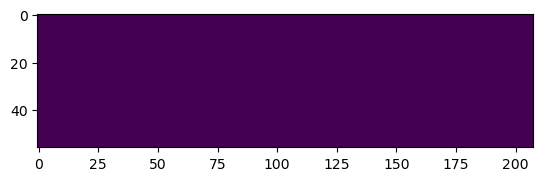

In [4]:
import matplotlib.pyplot as plt

plt.imshow(transformed_moving_image_yzx.max(0));

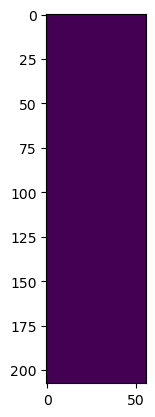

In [7]:
plt.imshow(transformed_moving_image_xzy.max(2));

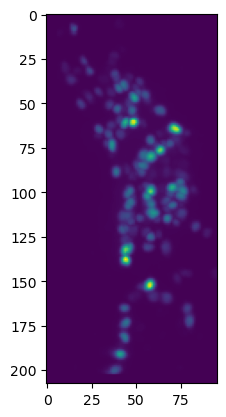

In [7]:
plt.imshow(transformed_moving_image_xzy.max(1));

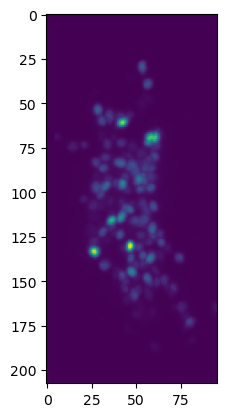

In [8]:
plt.imshow(transformed_moving_image_xyz.max(2));

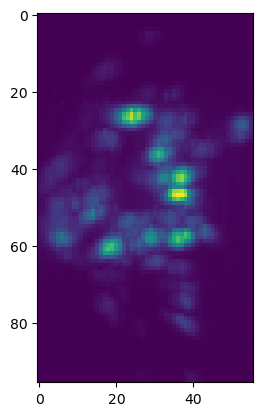

In [9]:
plt.imshow(transformed_moving_image_xyz.max(0));

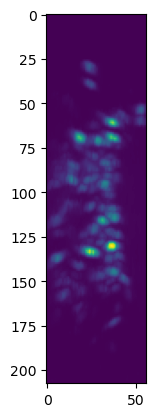

In [10]:
plt.imshow(transformed_moving_image_xyz.max(1));

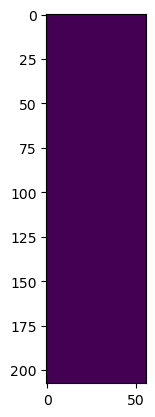

In [11]:
plt.imshow(transformed_moving_image_xzy.max(2));

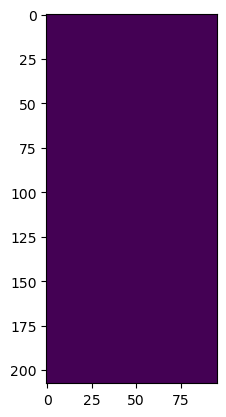

In [12]:
plt.imshow(transformed_moving_image_xzy.max(1));

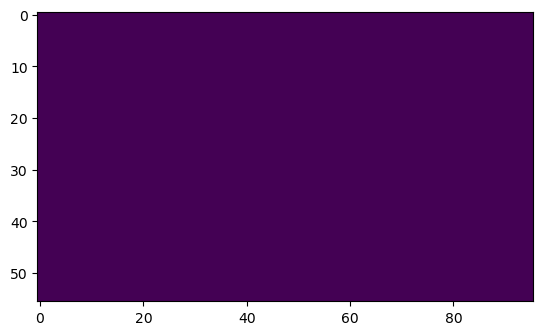

In [14]:
plt.imshow(transformed_moving_image_xzy.max(0));

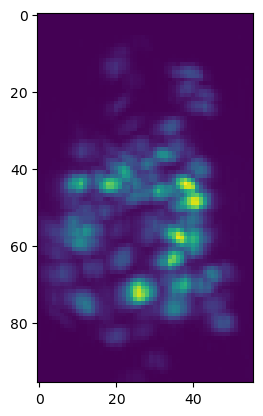

In [14]:
plt.imshow(transformed_moving_image_xyz.max(0));

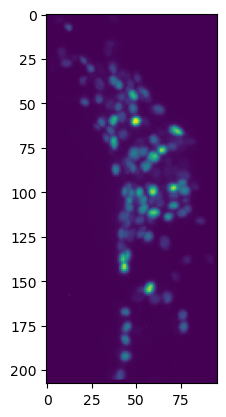

In [15]:
plt.imshow(resized_fixed_image_xyz.max(2));

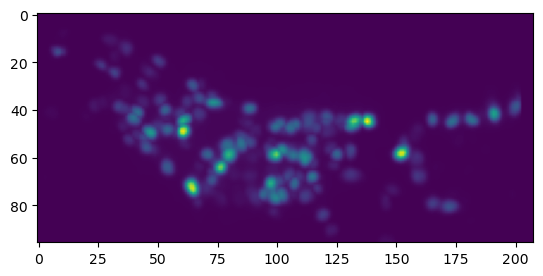

In [16]:
plt.imshow(transformed_moving_image_yzx.max(1));

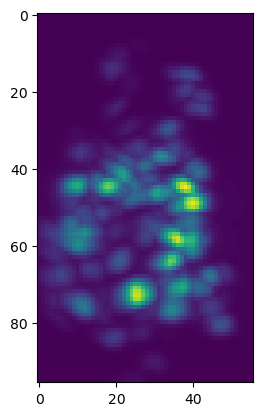

In [17]:
plt.imshow(transformed_moving_image_yzx.max(2));